In [2]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=d780694b007d61032e77500816525f8eb935d076f424627e4c9203aa0f2501f0
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

In [4]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "/kaggle/input/cityscape-csv/cityscape_train.csv"
TEST_PATH = "/kaggle/input/cityscape-csv/cityscape_test.csv"

In [5]:
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

In [6]:
def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  iresnet = InceptionResNetV2(include_top = False, weights = "imagenet", input_tensor = i)
  # iresnet.summary()

  conv1 = iresnet.get_layer("input_layer").output
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = iresnet.get_layer("activation").output
  conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)  
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = iresnet.get_layer("activation_3").output
  conv3 = ZeroPadding2D((1,1))(conv3)  
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = iresnet.get_layer("activation_74").output
  conv4 = ZeroPadding2D(((2,1),(2,1)))(conv4)  
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  

  # bottleneck
  conv5 = iresnet.get_layer("activation_161").output
  conv5 = ZeroPadding2D((1,1))(conv5) 
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  print(conv5.shape,conv4.shape)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

In [7]:
model = build(HEIGHT, WIDTH, 3)

74836368/74836368 [==============================] - 0s 0us/step
(None, 15, 20, 1792) (None, 30, 40, 512)


In [9]:
# !git clone https://gitlab.com/siddinc/new_depth.git ./data

In [10]:
# loading the dataset

def read_csv(csv_file_path):
  with open(csv_file_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    return [(row[0], row[1]) for row in csv_reader if len(row) > 0]

def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val

def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [12]:
def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=240)  # Resize height to 240
    image = cv2.resize(image, (320, 240))  # Ensure width is 320
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = imutils.resize(depth_map, height=240)  # Resize height to 240
    depth_map = cv2.resize(depth_map, (320, 240))  # Ensure width is 320
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map


In [13]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
  def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.shuffle = shuffle
    self.pred = pred
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    if self.pred:
      X = self.__data_generation(list_IDs_temp)
      return X
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

    if not self.pred:
      y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
        y[i,] = preprocess_depth_map(self.labels[ID], res)
      return X, y
    else:
      for i, ID in enumerate(list_IDs_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X

In [14]:
partition, labels = load_train_paths(TRAIN_PATH)
print(len(partition['train']), len(partition['validation']))

1100 472


In [18]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=16, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [19]:
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = Adam(lr=INIT_LR, amsgrad=True)
callbacks = [LearningRateScheduler(poly_decay)]

# custom loss
def depth_loss(y_true, y_pred):
  w1, w2, w3 = 1.0, 1.0, 0.3

  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [20]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])

In [21]:
# r = model.fit(training_generator, validation_data=validation_generator, epochs=15, callbacks=callbacks)

In [22]:
 # model.save("iresnetv2_cityscapes_15.keras")

In [23]:
# from tensorflow.keras.models import load_model
r = model.load_weights("/kaggle/input/irv2_cityscape/keras/default/1/iresnetv2_cityscapes_15.keras")

In [25]:
img_dm_pairs = read_csv('/kaggle/input/cityscape-csv/cityscape_test.csv')
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

500


In [26]:
x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
  x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
  y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)

In [27]:
print(model.evaluate(x_test, y_test))

16/16 [==============================] - 59s 2s/step - loss: 0.1226 - depth_acc: 0.9146
[0.12261872738599777, 0.9145557284355164]


In [28]:
y_pred = model.predict(x_test)  

y_true = y_test 

16/16 [==============================] - 8s 430ms/step


In [29]:
import time
import numpy as np
import matplotlib.pyplot as plt

start_time = time.time()
test_samples = model.predict(x_test)
end_time = time.time()
total_time = end_time - start_time
num_samples = len(x_test)
avg_time_per_image = total_time / num_samples
print(f"Average test time per image: {avg_time_per_image:.6f} seconds")


16/16 [==============================] - 7s 434ms/step
Average test time per image: 0.017160 seconds


In [35]:
import numpy as np

def calculate_metrics(pred, true):
    """Calculate precision, recall, F1 score, and accuracy for a single pair of prediction and ground truth."""
    tp = np.logical_and(pred, true).sum()  # True positives
    fp = np.logical_and(pred, np.logical_not(true)).sum()  # False positives
    fn = np.logical_and(np.logical_not(pred), true).sum()  # False negatives
    tn = np.logical_and(np.logical_not(pred), np.logical_not(true)).sum()  # True negatives
    
    # Precision, Recall, F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0.0
    
    return precision, recall, f1, accuracy

# Threshold predictions and ground truth
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)
y_true_binary = (y_true >= threshold).astype(int)

# Compute metrics for each sample
all_metrics = [calculate_metrics(y_pred_binary[i], y_true_binary[i]) for i in range(len(y_pred))]

# Separate precision, recall, F1 scores, and accuracy
precisions, recalls, f1_scores, accuracies = zip(*all_metrics)

# Calculate average precision, recall, F1 score, and accuracy
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracies)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")


Average Precision: 0.8485
Average Recall: 0.8117
Average F1 Score: 0.8184
Average Accuracy: 0.9149


Number of pixels used for evaluation: 768000


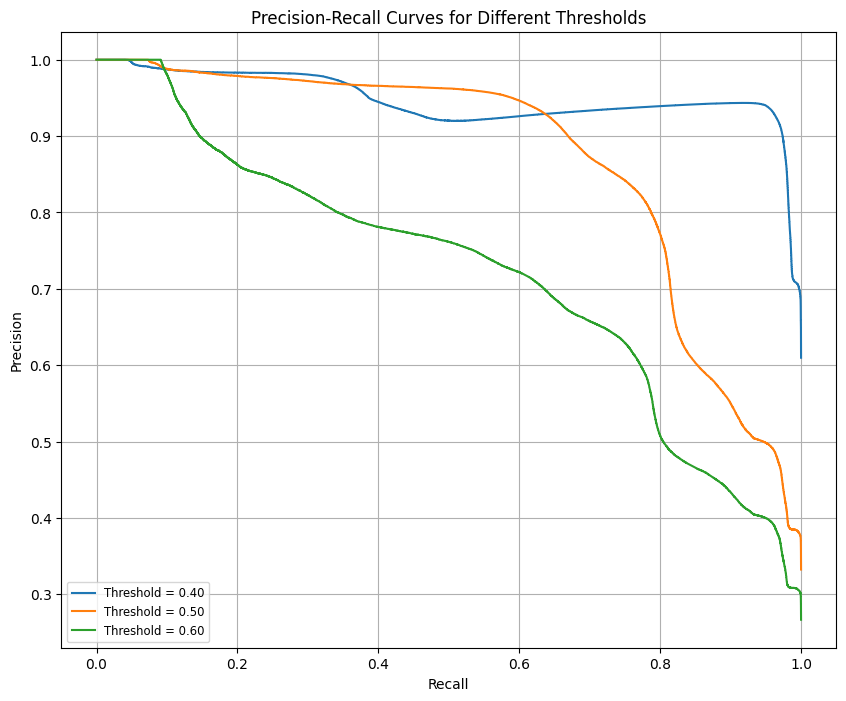

Number of pixels used for evaluation: 768000


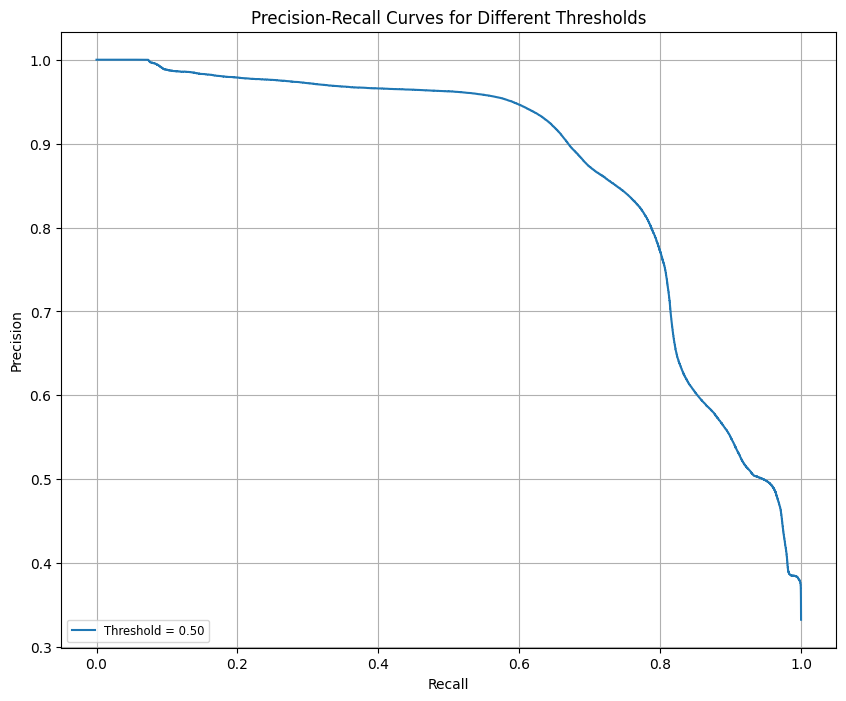

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

thresholds = [0.4, 0.5, 0.6]

precision_recall_data = []

y_true_flattened = np.concatenate([y_true[i].flatten() for i in range(10)])
y_pred_flattened = np.concatenate([y_pred[i].flatten() for i in range(10)])

print(f"Number of pixels used for evaluation: {len(y_true_flattened)}")

for threshold in thresholds:
    y_true_binary = (y_true_flattened >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_flattened)
    precision_recall_data.append((precision, recall, threshold))

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for precision, recall, threshold in precision_recall_data:
    plt.plot(recall, precision, label=f'Threshold = {threshold:.2f}')

# Finalize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Thresholds')
plt.legend(loc='lower left', fontsize='small')
plt.grid()
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

thresholds = [0.5]
precision_recall_data = []

y_true_flattened = np.concatenate([y_true[i].flatten() for i in range(10)])
y_pred_flattened = np.concatenate([y_pred[i].flatten() for i in range(10)])

print(f"Number of pixels used for evaluation: {len(y_true_flattened)}")

# Compute Precision-Recall for each threshold
for threshold in thresholds:
    y_true_binary = (y_true_flattened >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_flattened)
    precision_recall_data.append((precision, recall, threshold))

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for precision, recall, threshold in precision_recall_data:
    plt.plot(recall, precision, label=f'Threshold = {threshold:.2f}')

# Finalize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Thresholds')
plt.legend(loc='lower left', fontsize='small')
plt.grid()
plt.show()


In [38]:
import numpy as np

def calculate_iou(pred, true):
    """Calculate IoU for a single pair of prediction and ground truth."""
    intersection = np.logical_and(pred, true).sum()  # True positives (overlap)
    union = np.logical_or(pred, true).sum()  # Union of the two regions
    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Handle edge case (both empty)
    return intersection / union

# Assuming y_pred and y_true are arrays of shape (num_samples, height, width)
ious = [calculate_iou(y_pred[i], y_true[i]) for i in range(len(y_pred))]

# Calculate average IoU
avg_iou = np.mean(ious)
min_iou = np.min(ious)
max_iou = np.max(ious)

print(f"Average IoU: {avg_iou:.4f}")
print(f"Minimum IoU: {min_iou:.4f}")
print(f"Maximum IoU: {max_iou:.4f}")

16/16 [==============================] - 6s 424ms/step


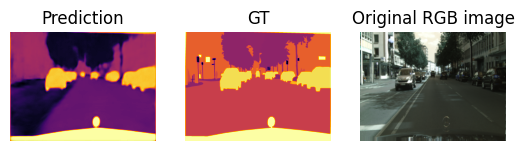

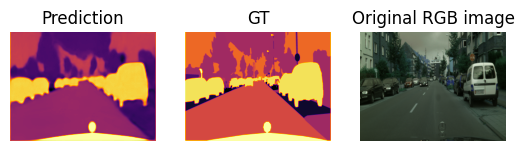

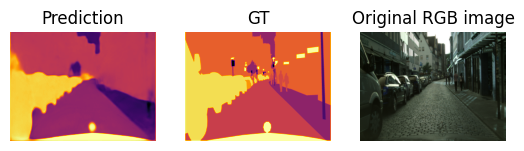

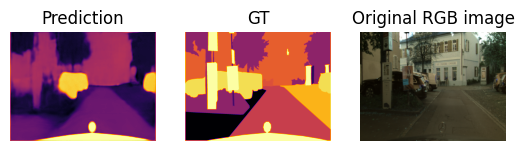

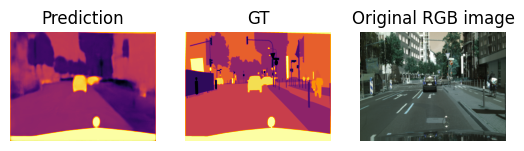

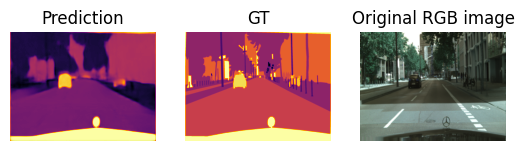

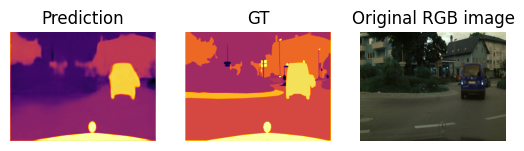

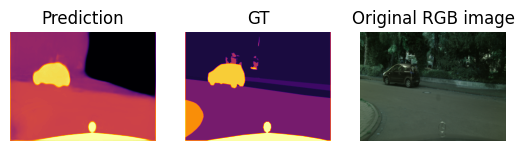

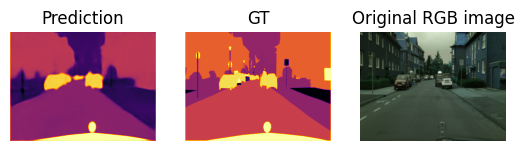

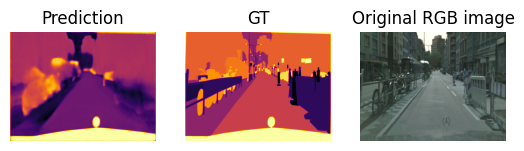

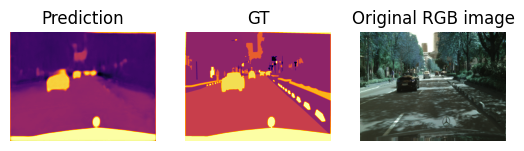

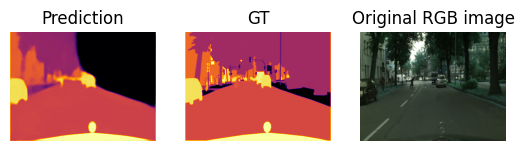

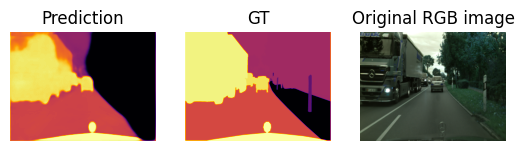

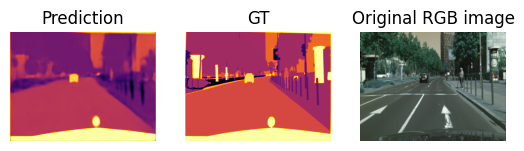

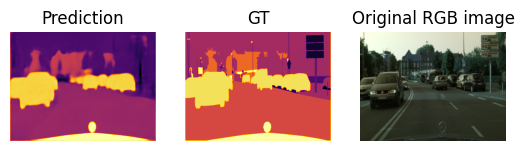

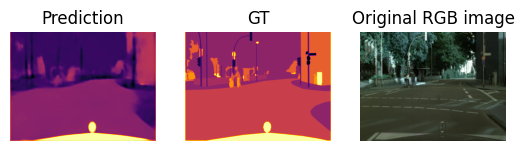

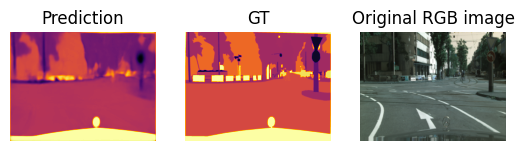

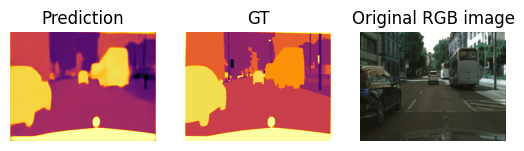

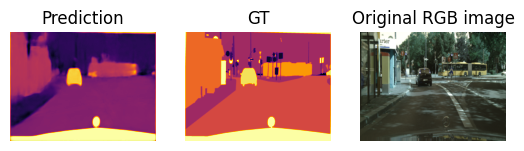

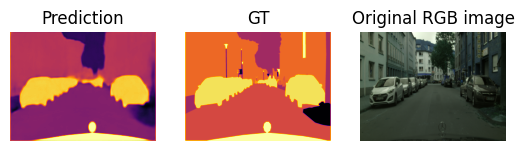

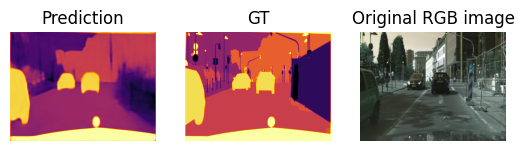

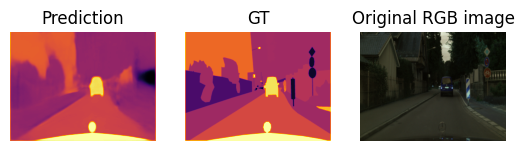

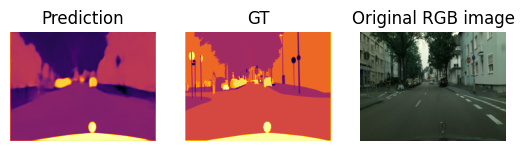

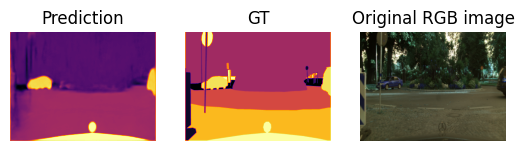

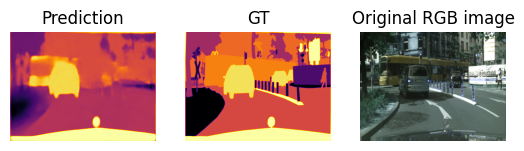

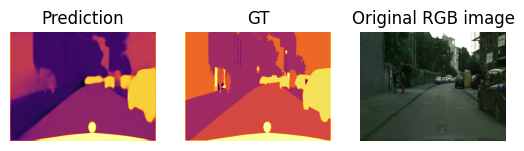

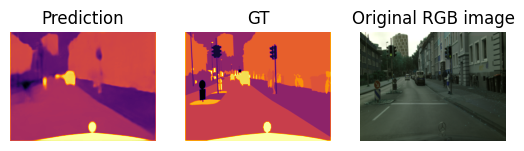

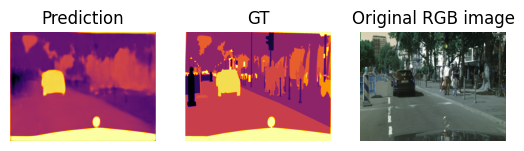

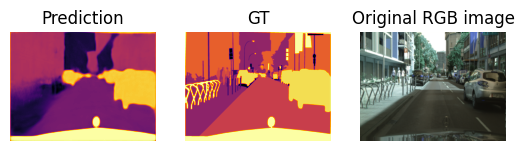

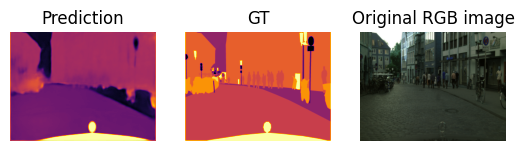

In [39]:
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(x_test)

for i in range(len(test_paths)-470):
  path = partition['test'][i]
  label_path = labels[path]
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)

  plt.subplot(1,3,1)
  plt.axis("off")
  plt.title("Prediction")
  plt.imshow(pred, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,2)
  plt.axis("off")
  plt.title("GT")
  img = preprocess_depth_map(label_path, horizontal_flip=False)
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap('inferno_r'))

  plt.subplot(1,3,3)
  plt.axis("off")
  plt.title("Original RGB image")
  img1 = preprocess_image(path, horizontal_flip=False)
  plt.imshow(img1)

  plt.show()